In [8]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader ,Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:
data_df=pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.dropna(inplace=True)
data_df.drop(["id"] , axis=1 ,inplace=True)
print("Output possibilities: ", data_df["Class"].unique()) # Possible Outputs
print("Data Shape (rows, cols): ", data_df.shape) # Print data shape
data_df.head()


Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Normalize the data

In [36]:
data_df.shape

(18185, 11)

In [12]:
data_df.Class.value_counts()

,count
Class,
1,9985
0,8200


In [33]:
data_df.iloc[0]

,0
Area,0.444368
MajorAxisLength,0.503404
MinorAxisLength,0.775435
Eccentricity,0.744658
ConvexArea,0.424873
EquivDiameter,0.666610
Extent,0.741661
Perimeter,0.537029
Roundness,0.844997
AspectRation,0.368316


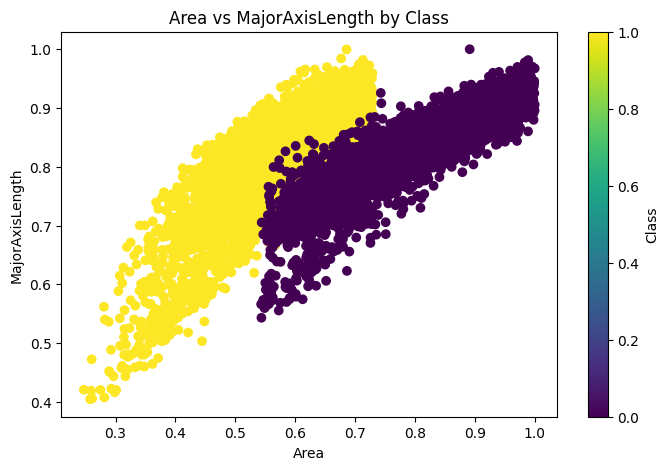

In [29]:
# Example: Scatter plot of Area vs. MajorAxisLength colored by Class
plt.figure(figsize=(8, 5))
plt.scatter(data_df['Area'], data_df['MajorAxisLength'], c=data_df['Class'], cmap='viridis')
plt.xlabel('Area')
plt.ylabel('MajorAxisLength')
plt.title('Area vs MajorAxisLength by Class')
plt.colorbar(label='Class')
plt.show()

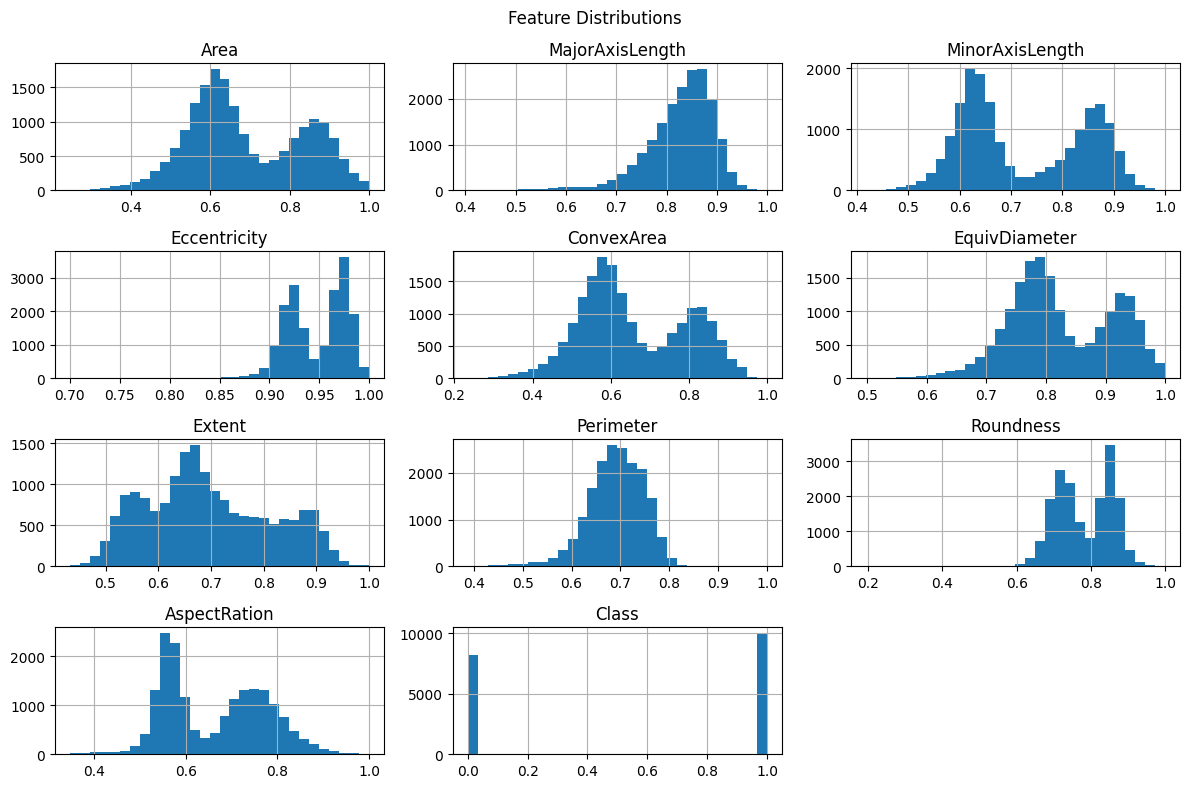

In [30]:
import matplotlib.pyplot as plt

# Plot histograms for all features
data_df.hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

In [31]:
before_normalize_data= data_df.copy()
for col in data_df.columns :
  data_df[col]=data_df[col]/data_df[col].abs().max()
data_df.head()


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


split data

Training Size 70%

Validation Size 15%

Testing Size 15%

In [37]:
#df.iloc[ row_selection , column_selection ]
X=np.array(data_df.iloc[:,:-1])
Y=np.array(data_df.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3) # Create the training split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) # Create the validation split
print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape


Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


In [38]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [41]:
BATCH_SIZE = 32
EPOCHS = 100
HIDDEN_NEURONS = 10
LR =0.1

In [17]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)


In [45]:
from torch import nn
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.layer_2 = nn.Linear(HIDDEN_NEURONS, HIDDEN_NEURONS)
        self.layer_3 = nn.Linear(HIDDEN_NEURONS, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = MyModel().to(device)
print(model)


MyModel(
  (layer_1): Linear(in_features=10, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


Params=(number of inputs×number of outputs)+number of outputs (biases)




When you create:

**nn.Linear(in_features, out_features)**

PyTorch automatically includes:

**Weights: shape → (out_features, in_features)**

**Bias: shape → (out_features,) (one bias per output neuron)**

Unless you set bias=False, every output neuron has exactly one bias term

In [46]:

model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
Total params: 231
Trainable params: 231
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [47]:

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= LR)


In [49]:
# Assuming you have these from your code
from sklearn.metrics import accuracy_score
import torch

# Lists to store metrics
total_loss_train = []
total_loss_val = []
total_acc_train = []
total_acc_val = []

# Training loop (example)
num_epochs = 100  # Adjust based on your setup
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Ensure labels are float
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()  # Shape: [batch_size]
        loss = criterion(outputs, labels)  # Shapes match
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()  # Threshold at 0.5
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    total_loss_train.append(train_loss)
    total_acc_train.append(train_acc)

    # Validation phase (similar changes)
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()  # Ensure labels are float
            outputs = model(inputs).squeeze()  # Shape: [batch_size]
            loss = criterion(outputs, labels)  # Shapes match
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(validation_dataloader)
    val_acc = accuracy_score(val_labels, val_preds)
    total_loss_val.append(val_loss)
    total_acc_val.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/100, Train Loss: 0.6829, Train Acc: 0.5509, Val Loss: 0.6829, Val Acc: 0.5396
Epoch 2/100, Train Loss: 0.6809, Train Acc: 0.5509, Val Loss: 0.6817, Val Acc: 0.5396
Epoch 3/100, Train Loss: 0.6797, Train Acc: 0.5509, Val Loss: 0.6807, Val Acc: 0.5396
Epoch 4/100, Train Loss: 0.6787, Train Acc: 0.5509, Val Loss: 0.6796, Val Acc: 0.5396
Epoch 5/100, Train Loss: 0.6777, Train Acc: 0.5509, Val Loss: 0.6788, Val Acc: 0.5396
Epoch 6/100, Train Loss: 0.6768, Train Acc: 0.5509, Val Loss: 0.6777, Val Acc: 0.5396
Epoch 7/100, Train Loss: 0.6757, Train Acc: 0.5509, Val Loss: 0.6763, Val Acc: 0.5396
Epoch 8/100, Train Loss: 0.6746, Train Acc: 0.5509, Val Loss: 0.6755, Val Acc: 0.5396
Epoch 9/100, Train Loss: 0.6734, Train Acc: 0.5509, Val Loss: 0.6740, Val Acc: 0.5396
Epoch 10/100, Train Loss: 0.6721, Train Acc: 0.5509, Val Loss: 0.6725, Val Acc: 0.5396
Epoch 11/100, Train Loss: 0.6707, Train Acc: 0.5509, Val Loss: 0.6714, Val Acc: 0.5396
Epoch 12/100, Train Loss: 0.6692, Train Acc: 0.5509,

In [50]:
def predict_single_row(model, row, device):
    model.eval()
    with torch.no_grad():
        if isinstance(row, torch.Tensor):
            row_tensor = row.clone().detach().to(device).unsqueeze(0)
        else:
            row_tensor = torch.tensor(row, dtype=torch.float32).to(device).unsqueeze(0)

        output = model(row_tensor)

        # Binary classification case
        predicted_class = torch.round(torch.sigmoid(output)).item()
    return predicted_class


In [51]:
# Pick a row and its true label
row = X_test[0]  # first row from test set
true_label = y_test[0].item()

# Predict
predicted = predict_single_row(model, row, device)

print(f"True label: {true_label}")
print(f"Predicted label: {predicted}")


True label: 1.0
Predicted label: 1.0


In [52]:
### TESTING ###
model.eval()
total_loss_test = 0
total_acc_test = 0

with torch.inference_mode():
    for inputs, labels in testing_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        y_logits = model(inputs).squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Loss
        loss = criterion(y_logits, labels)
        total_loss_test += loss.item()

        # Accuracy
        total_acc_test += (y_pred == labels).sum().item()

# Print test results
print(f"Test Loss: {total_loss_test / len(testing_dataloader):.4f} | "
      f"Test Acc: {total_acc_test / len(testing_data) * 100:.2f}%")


Test Loss: 0.0541 | Test Acc: 98.61%


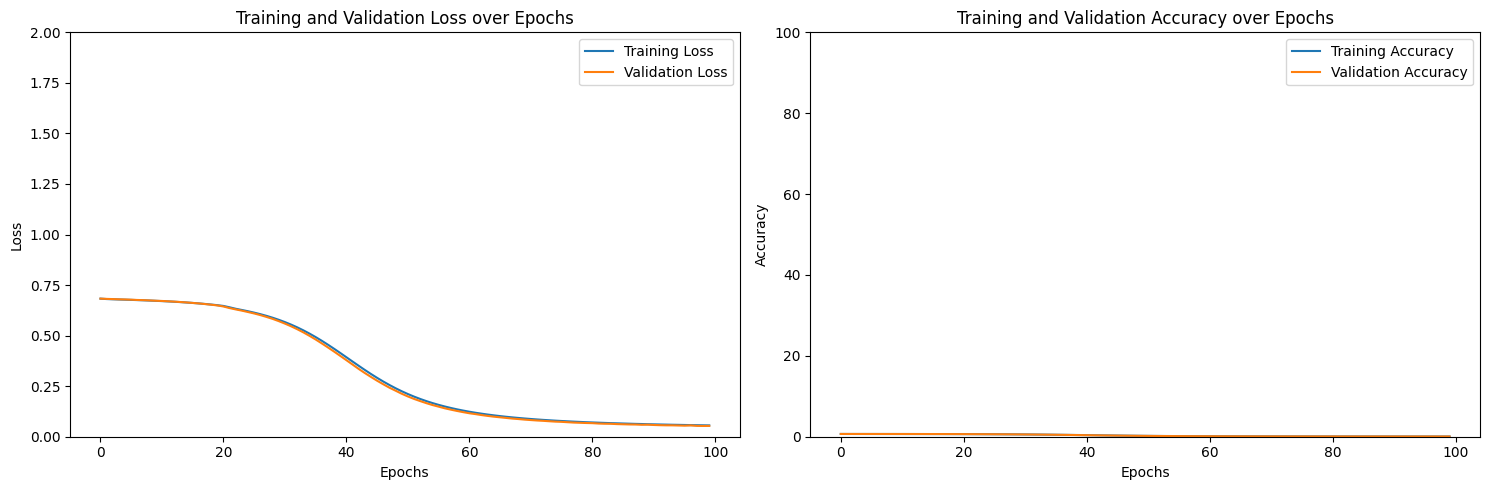

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train, label='Training Loss')
axs[0].plot(total_loss_val, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_loss_train, label='Training Accuracy')
axs[1].plot(total_loss_val, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [62]:
model.eval()
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  X_test_tensor = torch.FloatTensor(X_test)
  y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)
  device = torch.device("cpu")
  y_preds = model(X_test_tensor)
y_preds

tensor([[ 5.5847e+00],
        [-6.4715e+00],
        [-4.0109e-03],
        ...,
        [-6.2121e+00],
        [-5.5089e+00],
        [ 4.4022e+00]])

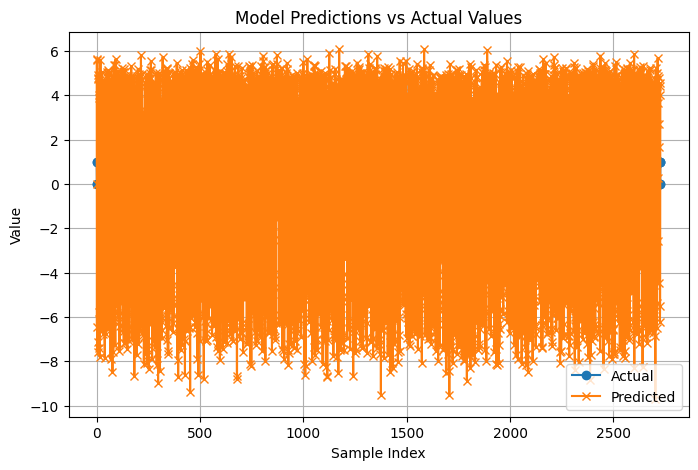

In [65]:
import matplotlib.pyplot as plt
import torch

# Convert tensors to NumPy for plotting
y_preds_numpy = y_preds.cpu().numpy()
y_test_numpy = y_test_tensor.cpu().numpy()

plt.figure(figsize=(8, 5))
plt.plot(y_test_numpy, label="Actual", marker='o')
plt.plot(y_preds_numpy, label="Predicted", marker='x')

plt.title("Model Predictions vs Actual Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [69]:
import torch

# 1. Take one sample from your dataset
single_row = X_test_tensor[0]  # first row
true_label = y_test_tensor[0]  # correct label

# 2. Add batch dimension (model expects [batch_size, features])
single_row = single_row.unsqueeze(0)

# 3. Put model in evaluation mode and disable gradients
model.eval()
with torch.inference_mode():
    pred_logits = model(single_row)  # raw output (logits)
    pred_prob = torch.sigmoid(pred_logits)  # convert to probability for binary classification
    pred_class = torch.round(pred_prob)  # 0 or 1

# 4. Show result
print(f"True label: {true_label.item()}")
print(f"Predicted probability: {pred_prob.item():.4f}")
print(f"Predicted class: {int(pred_class.item())}")


True label: 1.0
Predicted probability: 0.9963
Predicted class: 1


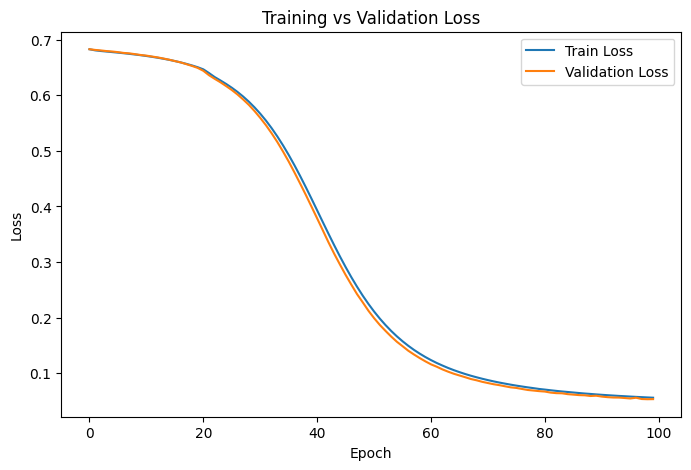

In [70]:
plt.figure(figsize=(8,5))
plt.plot(total_loss_train, label='Train Loss')
plt.plot(total_loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()
